<a href="https://colab.research.google.com/github/nts-e/autoencoders_x_ray/blob/main/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Auto Encoder - Chest X-Ray Images (Pneumonia)**

* Based on a Kaggle [dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)
* Implements an Under Complete and Denoising autoencoders



## Data loading and initializations

In [ ]:
RANDOM_STATE                  = 2

USE_GOOGLE_DRIVE_FOR_FILES    = True
DATA_FOLDER_PATH              = ""

if USE_GOOGLE_DRIVE_FOR_FILES:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing           import image
from tensorflow.keras.optimizers              import Adam
from keras                                    import Input, Sequential
from keras.callbacks                          import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.metrics                 import Precision, Recall
from keras.layers                             import MaxPooling2D, Dense, BatchNormalization, Dropout, Activation, Conv2D, Conv2DTranspose, concatenate, UpSampling2D
from keras.models                             import Model, load_model
from keras.utils                              import plot_model
from sklearn.preprocessing                    import label_binarize
from sklearn.model_selection                  import train_test_split
from tqdm                                     import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import cv2

Load the CSV file prepared in advance in the TL.ipynb notebook

In [ ]:
df = pd.read_csv(f"{DATA_FOLDER_PATH}/chest_xray.csv")

In [ ]:
input_size = (256, 256)

**Note:** load the pickle file prepared in the TL notebook. skip the loading code part.

In [ ]:
# load X
with open(f"{DATA_FOLDER_PATH}/X_256_256_raw.pkl", 'rb') as f:
    X = pickle.load(f)

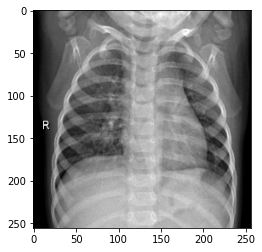

In [ ]:
plt.imshow(X[0].reshape(input_size))
plt.gray()

In [ ]:
# done once and can be skipped

print("Loading images to variable X...")
l_img = []
file_paths = list(df['path'].values)

for i in tqdm(range(len(file_paths))):
  img = cv2.resize(cv2.imread(file_paths[i], cv2.IMREAD_GRAYSCALE), input_size)
  l_img.append(img)
  
X = np.array(l_img)

# save X
with open(f"{DATA_FOLDER_PATH}/X_256_256_raw.pkl", 'wb') as f:
    pickle.dump(X, f)

Loading images to variable X...


100%|██████████| 5856/5856 [53:27<00:00,  1.83it/s]


## Preprocessing and split

In [ ]:
X = np.expand_dims(X, -1)
X = X.astype('float32') / 255.
y = np.array(df['label'])

X.shape

(5856, 256, 256, 1)

In [ ]:
# Split: 70% train, 10% validation, 20% test
X_temp, X_test, y_temp, y_test= train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.12, random_state=RANDOM_STATE)

print(f'Train: {X_train.shape}', f'Validation: {X_valid.shape}', f'Test: {X_test.shape}', sep="\n")

Train: (4121, 256, 256, 1)
Validation: (563, 256, 256, 1)
Test: (1172, 256, 256, 1)


## Model

In [ ]:

input = Input(shape=(input_size[0],input_size[1],1), name='input')
    
#enoder 
x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv_e_01')(input)
x = MaxPooling2D((2,2), padding='same', name='pool_e_01')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv_e_02')(x)
x = MaxPooling2D((2,2), padding='same', name='pool_e_02')(x)
x = Conv2D(4, (3,3), activation='relu', padding='same', name='conv_e_03')(x) # try: conv: (1,1)
encoder = MaxPooling2D((2,2), padding='same', name='pool_e_03')(x)

#decoder
x = Conv2D(4, (3,3), activation='relu', padding='same', name='conv_d_01')(encoder)
x = UpSampling2D((2,2), name='up_d_01')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv_d_02')(x)
x = UpSampling2D((2,2), name='up_d_02')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv_d_03')(x)
x = UpSampling2D((2,2), name='up_d_03')(x)

decoder = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) 

autoencoder = Model(input, decoder)
autoencoder.compile(optimizer=Adam(1e-3), loss='mse') # binary_crossentropy
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 1)]     0         
                                                                 
 conv_e_01 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 pool_e_01 (MaxPooling2D)    (None, 128, 128, 64)      0         
                                                                 
 conv_e_02 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 pool_e_02 (MaxPooling2D)    (None, 64, 64, 64)        0         
                                                                 
 conv_e_03 (Conv2D)          (None, 64, 64, 4)         2308      
                                                                 
 pool_e_03 (MaxPooling2D)    (None, 32, 32, 4)         0     

Compare sizes

In [ ]:
before = 256*256
after = 32*32*4
print(f'before={before}, after={after}, factor={before/after}')

before=65536, after=4096, factor=16.0


In [ ]:
class SavePlotsCallback(Callback):
       
    def __init__(self, x, y, classifier, number_of_images, epoc_snapshots, idx=None):
        self.x = x
        self.y = y
        if idx==None:
          self.idx = np.random.randint(0, len(x), number_of_images)
        else:
          self.idx = idx
        self.epoc_snapshots = epoc_snapshots
        self.classifier = classifier
        self.predicted_images = []
    
    def on_epoch_end(self, epoch, logs=None):
      if epoch in self.epoc_snapshots:
        self.predicted_images.append(self.classifier.predict(self.x[self.idx]))

In [ ]:
epochs = 151
batch_size = 32
samples_to_plot = 10

validation_data = (X_valid, X_valid)
sp = SavePlotsCallback(X_valid, X_valid, autoencoder, samples_to_plot, epoc_snapshots=[1, 10, 25, 50, 100, 150])

In [ ]:
# load model
# with open(f"{DATA_FOLDER_PATH}/AE_20221224.pkl", 'rb') as f:
#     autoencoder = pickle.load(f)

In [ ]:

history = autoencoder.fit(x=X_train, y=X_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(X_valid, X_valid), callbacks=[sp])


Epoch 1/151
  6/129 [>.............................] - ETA: 19s - loss: 0.0534

129/129 [==============================] - 30s 194ms/step - loss: 0.0112 - val_loss: 0.0038
Epoch 2/151
129/129 [==============================] - 23s 178ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 3/151
129/129 [==============================] - 23s 175ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 4/151
129/129 [==============================] - 22s 174ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 5/151
129/129 [==============================] - 22s 174ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/151
129/129 [==============================] - 23s 175ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/151
129/129 [==============================] - 23s 175ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/151
129/129 [==============================] - 23s 175ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/151
129/129 [==============================] - 23s 175ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/151
129/129 [==============================] - 23s 175ms/step - los

In [ ]:
sp.idx

array([194, 294, 315, 246, 260,  53, 113, 444, 400, 200])

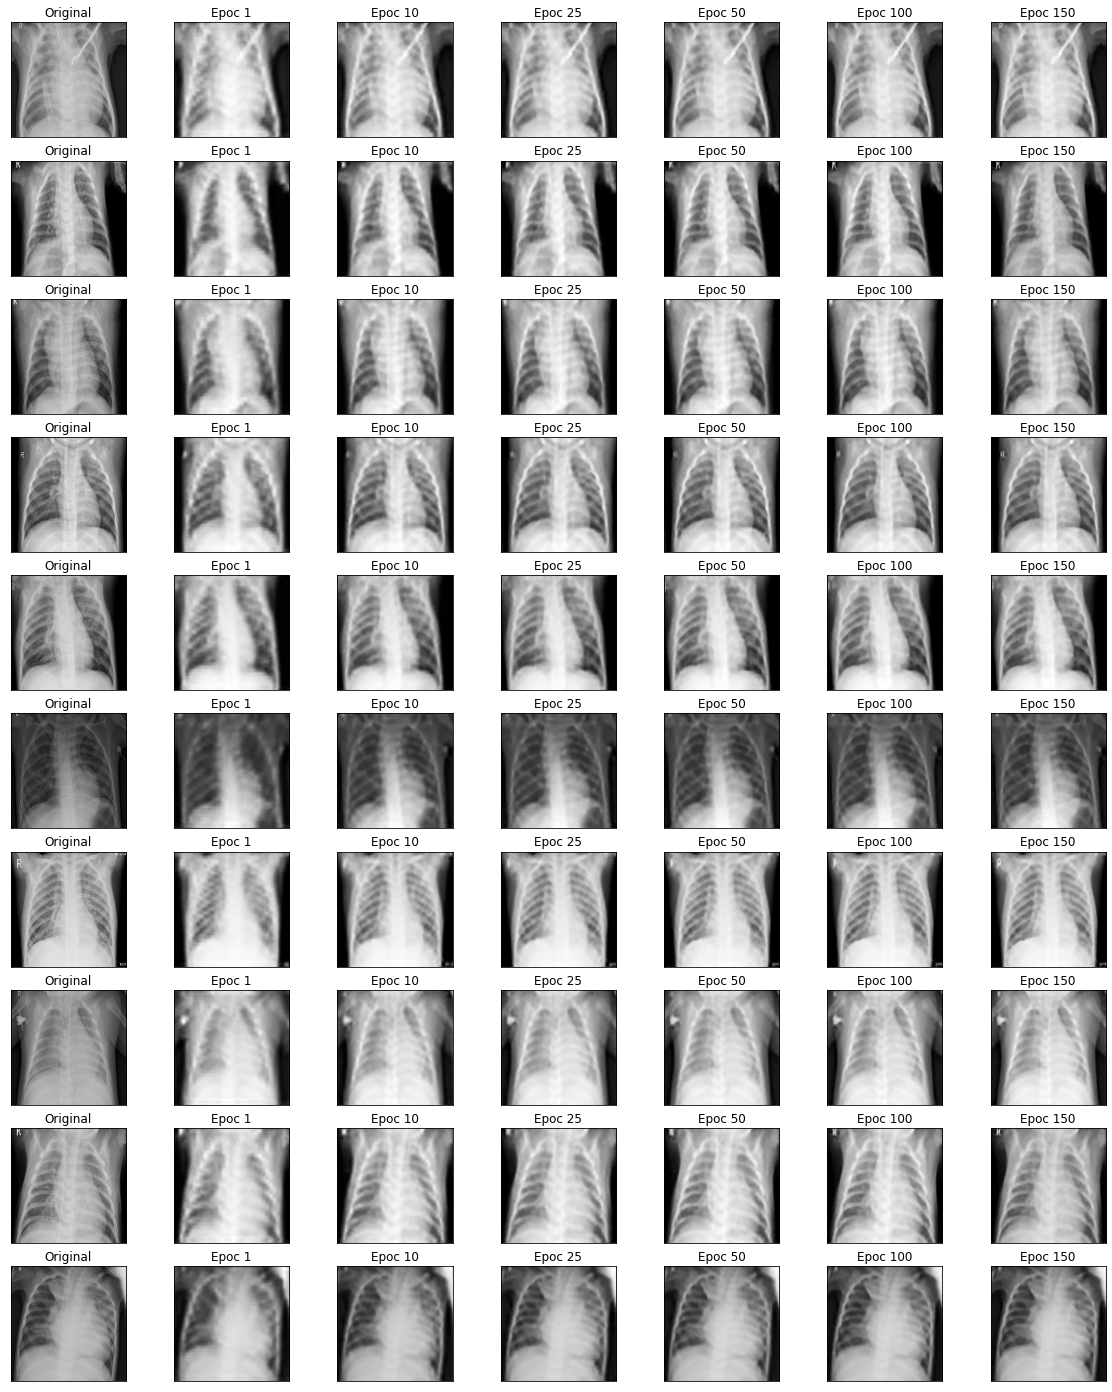

In [ ]:
def plot_samples(samples_to_plot, spo, X):

  reconstructions = len(spo.predicted_images)

  plt.figure(figsize=(20, 25))

  for r in range(reconstructions+1):

    for i in range(samples_to_plot):
      ax = plt.subplot(samples_to_plot, reconstructions+1, i*(reconstructions+1) + r+1)
      
      if r==0:
        plt.imshow(X[spo.idx[i]].reshape(256, 256))
        ax.set_title('Original')

      else:
        plt.imshow(spo.predicted_images[r-1][i].reshape(256, 256))
        ax.set_title(f'Epoc {spo.epoc_snapshots[r-1]}')

      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

  plt.show()

plot_samples(10, sp, X_valid)


In [ ]:
# save model
with open(f"{DATA_FOLDER_PATH}/AE_20221224.pkl", 'wb') as f:
    pickle.dump(autoencoder, f)

## Latent code

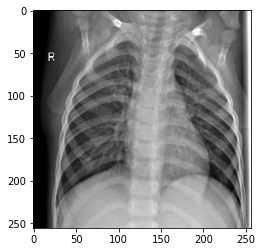

In [ ]:
example = X_valid[1]
plt.imshow(example.reshape(256, 256));

In [ ]:
example.shape

(256, 256, 1)

In [ ]:
layer_output = autoencoder.get_layer('pool_e_03').output

intermediate_model = Model(inputs=autoencoder.input,outputs=layer_output)

encoded_train = intermediate_model.predict(X_train)
encoded_valid = intermediate_model.predict(X_valid)
encoded_test = intermediate_model.predict(X_test)
print(np.shape(encoded_train))


37/37 [==============================] - 1s 38ms/step
(4121, 32, 32, 4)


In [ ]:
intermediate_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 1)]     0         
                                                                 
 conv_e_01 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 pool_e_01 (MaxPooling2D)    (None, 128, 128, 64)      0         
                                                                 
 conv_e_02 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 pool_e_02 (MaxPooling2D)    (None, 64, 64, 64)        0         
                                                                 
 conv_e_03 (Conv2D)          (None, 64, 64, 4)         2308      
                                                                 
 pool_e_03 (MaxPooling2D)    (None, 32, 32, 4)         0   

In [ ]:
img_index = 2
encoded_train[img_index][:,:,0:1].shape

(32, 32, 1)

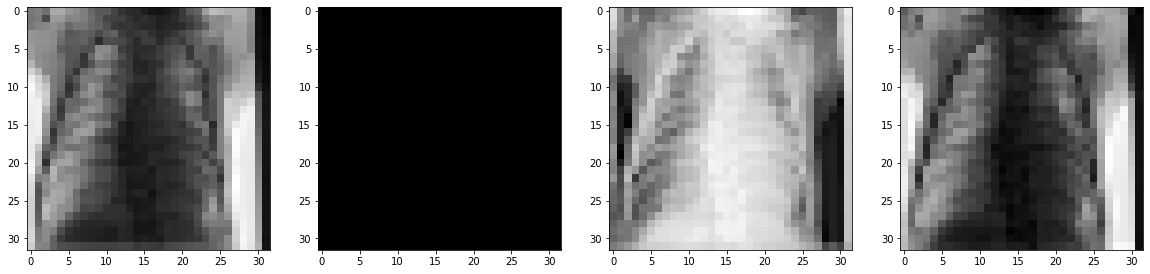

In [ ]:
plt.figure(figsize=(20, 25))
for i in range(4):
  ax = plt.subplot(1, 4, i+1)
  plt.imshow(encoded_train[img_index][:,:,i:i+1].reshape(32, 32));

Can the latent vector predict pneumonia?

In [ ]:
encoded_train.shape

(4121, 32, 32, 4)

In [ ]:
# encoded_input = intermediate_prediction.reshape(-1,32*32*4)
# encoded_input.shape

(4121, 4096)

In [ ]:
optimizer = Adam(learning_rate=1e-3) 

input = Input(shape=(4096,), name='input')
    
x = Dense(64)(input)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input, outputs=predictions)

model.compile(optimizer=optimizer,  loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 262,273
Trainable params: 262,273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
validation_data = (encoded_valid.reshape(-1,32*32*4), y_valid)
history = model.fit(x=encoded_train.reshape(-1,32*32*4), y=y_train, batch_size=32, epochs=10, validation_data=validation_data)

Epoch 1/10
129/129 [==============================] - 1s 4ms/step - loss: 0.1251 - accuracy: 0.9505 - precision: 0.9621 - recall: 0.9704 - val_loss: 0.1822 - val_accuracy: 0.9361 - val_precision: 0.9427 - val_recall: 0.9739
Epoch 2/10
129/129 [==============================] - 1s 4ms/step - loss: 0.1117 - accuracy: 0.9532 - precision: 0.9650 - recall: 0.9711 - val_loss: 0.1791 - val_accuracy: 0.9290 - val_precision: 0.9569 - val_recall: 0.9479
Epoch 3/10
129/129 [==============================] - 1s 4ms/step - loss: 0.1001 - accuracy: 0.9607 - precision: 0.9696 - recall: 0.9767 - val_loss: 0.1803 - val_accuracy: 0.9361 - val_precision: 0.9531 - val_recall: 0.9621
Epoch 4/10
129/129 [==============================] - 1s 4ms/step - loss: 0.1030 - accuracy: 0.9592 - precision: 0.9696 - recall: 0.9747 - val_loss: 0.2173 - val_accuracy: 0.9218 - val_precision: 0.9725 - val_recall: 0.9218
Epoch 5/10
129/129 [==============================] - 1s 4ms/step - loss: 0.1232 - accuracy: 0.9493 - pr

In [ ]:
def f1(precision, recall):
  return 2 / ((1/precision) + (1/recall))

In [ ]:
model.evaluate(encoded_test.reshape(-1,32*32*4), y_test)

37/37 [==============================] - 0s 3ms/step - loss: 0.1271 - accuracy: 0.9625 - precision: 0.9618 - recall: 0.9870


[0.12713541090488434,
 0.9624573588371277,
 0.9618496894836426,
 0.9869513511657715]

In [ ]:
f1(0.9618496894836426, 0.9869513511657715)

0.9742388585116073

## Adding noise

In [ ]:
#X_noisy = X.copy()

In [ ]:
def add_noise(img, mean, var):
  img_height, image_width, channels = img.shape
  sigma = var ** 0.5
  gauss = np.random.normal(loc=mean,scale=sigma, size=(img_height, image_width))
  gauss = gauss.reshape(img_height, image_width,channels)
  return img + gauss

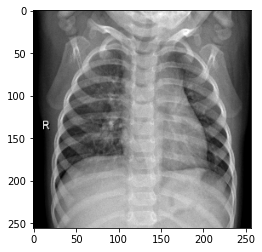

In [ ]:
plt.imshow(X[0].reshape(256,256));

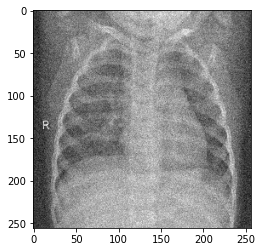

In [ ]:
plt.imshow(add_noise(X[0],0,0.01).reshape(256,256));

In [ ]:
noisy_images = []
for image in X:
  noisy_images.append(add_noise(image,0,0.01))


In [ ]:
X_noisy = np.array(noisy_images)
X_noisy.shape

(5856, 256, 256, 1)

In [ ]:
# Split: 70% train, 10% validation, 20% test
X_noisy_temp, X_noisy_test= train_test_split(X_noisy, test_size=0.2, random_state=RANDOM_STATE)
X_noisy_train, X_noisy_valid= train_test_split(X_noisy_temp, test_size=0.12, random_state=RANDOM_STATE)

print(f'Train: {X_noisy_train.shape}', f'Validation: {X_noisy_valid.shape}', f'Test: {X_noisy_test.shape}', sep="\n")

Train: (4121, 256, 256, 1)
Validation: (563, 256, 256, 1)
Test: (1172, 256, 256, 1)


In [ ]:
input = Input(shape=(input_size[0],input_size[1],1), name='input')
    
#enoder 
x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv_e_01')(input)
x = MaxPooling2D((2,2), padding='same', name='pool_e_01')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv_e_02')(x)
x = MaxPooling2D((2,2), padding='same', name='pool_e_02')(x)
x = Conv2D(4, (3,3), activation='relu', padding='same', name='conv_e_03')(x)
encoder = MaxPooling2D((2,2), padding='same', name='pool_e_03')(x)

#decoder
x = Conv2D(4, (3,3), activation='relu', padding='same', name='conv_d_01')(encoder)
x = UpSampling2D((2,2), name='up_d_01')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv_d_02')(x)
x = UpSampling2D((2,2), name='up_d_02')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv_d_03')(x)
x = UpSampling2D((2,2), name='up_d_03')(x)

decoder = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) 

denoising_autoencoder = Model(input, decoder)
denoising_autoencoder.compile(optimizer=Adam(1e-3), loss='mse') 

# binary_crossentropy
#denoising_autoencoder.summary()

In [ ]:
epochs = 151
batch_size = 32
samples_to_plot = 10

validation_data = (X_noisy_valid, X_valid)

# initialize the callback with the indices that were previously sampled
sp_noise = SavePlotsCallback(X_noisy_valid, X_valid, denoising_autoencoder, samples_to_plot, epoc_snapshots=[1, 10, 25, 50, 100, 150], idx = [194, 294, 315, 246, 260,  53, 113, 444, 400, 200])

history = denoising_autoencoder.fit(x=X_noisy_train, y=X_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=validation_data, callbacks=[sp_noise])


Epoch 1/151
  6/129 [>.............................] - ETA: 19s - loss: 0.0578

129/129 [==============================] - 24s 186ms/step - loss: 0.0101 - val_loss: 0.0032
Epoch 2/151
129/129 [==============================] - 22s 171ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 3/151
129/129 [==============================] - 22s 168ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 4/151
129/129 [==============================] - 22s 169ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/151
129/129 [==============================] - 22s 169ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/151
129/129 [==============================] - 22s 171ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/151
129/129 [==============================] - 22s 170ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/151
129/129 [==============================] - 22s 171ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 9/151
129/129 [==============================] - 22s 171ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/151
129/129 [==============================] - 22s 171ms/step - los

In [ ]:
# save model
with open(f"{DATA_FOLDER_PATH}/AE_Denoising_20221224.pkl", 'wb') as f:
    pickle.dump(denoising_autoencoder, f)

In [ ]:
sp_noise.idx

array([298, 551, 238, 116, 125,   6, 151, 102, 488,  53])

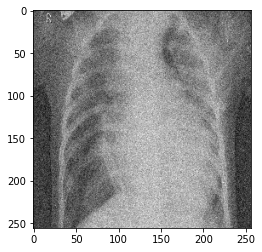

In [ ]:
plt.imshow(X_noisy_valid[298].reshape(256,256))

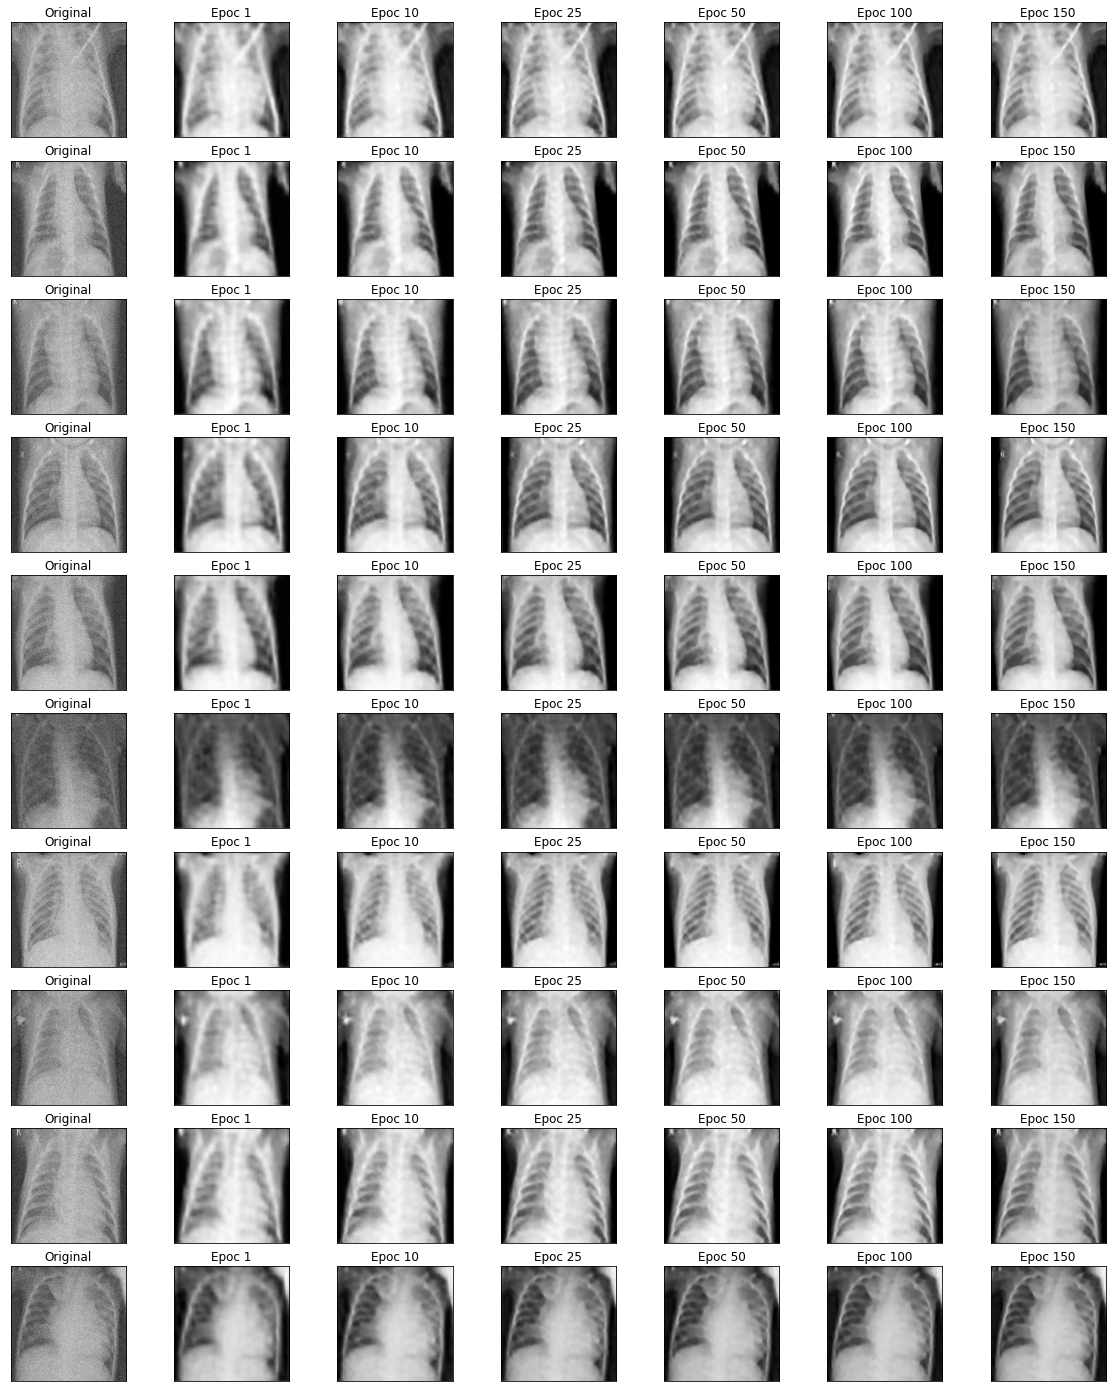

In [ ]:
plot_samples(10, sp_noise, X_noisy_valid)
